# Variational Quantum Linear Solver (VQLS)

## Example 1: Solve Ax = b where A ={{1 0},{0 2}} and b = 0.707 {1 1}

In [23]:
from qiskit import QuantumCircuit,transpile
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2
from qiskit.quantum_info import Operator
from scipy.optimize import minimize
import numpy as np

estimator = EstimatorV2()

I = SparsePauliOp.from_list([("I", 1.0)])
Z = SparsePauliOp.from_list([("Z", 1.0)])
X = SparsePauliOp.from_list([("X",1.0)])

#Step 1: Define operator A
A_op = 0.5 * (I + Z) + (I - Z)

#Step 2: Create |b><b| operator
b_op = 0.5 * (I + X)

#Step 3: create Hamiltonian H = A^+ (I - |b><b| ) A
Hamiltonian = A_op @ (I - b_op) @ A_op

#checking H is hermitian
print("Is Hermitian?", np.allclose(Hamiltonian.to_matrix(), Hamiltonian.to_matrix().conj().T))

#Checking any imaginary coefficients
print("Imag part of coeffs:", np.imag(Hamiltonian.coeffs).max())

#Display the Hamiltonian as matrix
print("Cost_Hamiltonian:",Hamiltonian.to_matrix())

# Make the operator Hermitian (just in case)
Hamiltonian = 0.5 * (Hamiltonian + Hamiltonian.adjoint())

# Strip all imaginary parts: only real part is needed
Hamiltonian = SparsePauliOp(Hamiltonian.paulis, coeffs=np.real(Hamiltonian.coeffs))

#Step 4: Create Ansatz
def ansatz(params):
    qc = QuantumCircuit(1)
    qc.ry(params[0],0)
    return qc

#Step5:Cost evaluation
def costfunction(params):
    state = ansatz(params)
    job = estimator.run([(state,Hamiltonian)])
    result = job.result()
    exact_value = float(result[0].data.evs)
    return exact_value

#Step 6: Optimization
initial_params = [0.1]
result = minimize(costfunction, initial_params, method='COBYLA')
print("Optimal Parameters:", result.x)
print("Minimum Cost:", result.fun)


Is Hermitian? True
Imag part of coeffs: 0.5
Cost_Hamiltonian: [[ 0.5+0.j -1. +0.j]
 [-1. +0.j  2. +0.j]]
Optimal Parameters: [0.92725]
Minimum Cost: 1.2779172164911756e-09


## Example 2: A = {{3/4 1/4},{1/4 3/4}} and b = {0 1}

In [30]:
from qiskit import QuantumCircuit,transpile
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2
from qiskit.quantum_info import Operator
from scipy.optimize import minimize
import numpy as np

estimator = EstimatorV2()

I = SparsePauliOp.from_list([("I", 1.0)])

#Step 1: Operator A
A_mat = np.array([[3/4,1/4],[1/4,3/4]])
A_op = SparsePauliOp.from_operator(A_mat)

#Step2: Operator from b (|b><b|)
b_mat = np.array([[0,0],[0,1]])
b_op = SparsePauliOp.from_operator(b_mat)

#step3: Cost Hamiltonian
Ham = A_op @ (I - b_op) @ A_op

#checking H is hermitian
print("Is Hermitian?", np.allclose(Ham.to_matrix(), Ham.to_matrix().conj().T))

#Checking any imaginary coefficients
print("Imag part of coeffs:", np.imag(Ham.coeffs).max())

#Display the Hamiltonian as matrix
print("Cost_Hamiltonian:",Ham.to_matrix())

# Make the operator Hermitian (just in case)
Ham = 0.5 * (Ham + Ham.adjoint())

# Strip all imaginary parts: only real part is needed
Ham = SparsePauliOp(Ham.paulis, coeffs=np.real(Ham.coeffs))

#Step 4: Create ansatz
def ansatz(params):
    qc = QuantumCircuit(1)
    qc.ry(params[0],0)
    return qc

#Step 5: evaluate cost function
def costfunc(params):
    state = ansatz(params)
    job = estimator.run([(state,Ham)])
    result = job.result()
    value  = result[0].data.evs
    return value

#step 6: optimization
initial_params = [0.1]
result = minimize(costfunc, initial_params, method='COBYLA')
print("Optimal Parameters:", result.x)
print("Minimum Cost:", result.fun)


Is Hermitian? True
Imag part of coeffs: 0.09375
Cost_Hamiltonian: [[0.5625+0.j 0.1875+0.j]
 [0.1875+0.j 0.0625+0.j]]
Optimal Parameters: [-2.4981]
Minimum Cost: 1.117039793996355e-11


## Example 3: For a two-qubit system

For a 4x4 matrix, A = {{4 1 0 0},{1 3 1 0},{0 1 2 1},{0 0 1 1}}, b = {0 1 2 1} 

<IPython.core.display.Latex object>

ParameterView([ParameterVectorElement(θ[0]), ParameterVectorElement(θ[1]), ParameterVectorElement(θ[2]), ParameterVectorElement(θ[3]), ParameterVectorElement(θ[4]), ParameterVectorElement(θ[5])])
6


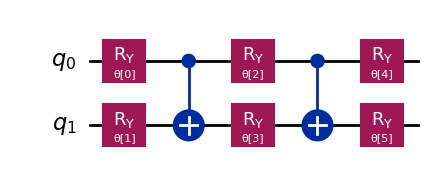

In [20]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector,DensityMatrix
import numpy as np

b_vec = np.array([0, 1, 2, 1])
b_vec = b_vec / np.linalg.norm(b_vec)

bqs = DensityMatrix(b_vec)
display(bqs.draw("latex"))

from qiskit.circuit.library import n_local

twolocal = n_local(2, rotation_blocks="ry", entanglement_blocks="cx", entanglement="linear", reps=2)
print(twolocal.parameters)
print(twolocal.num_parameters)

display(twolocal.draw("mpl"))

Is Hermitian? True
Imag part of coeffs: 0.5
Cost_Hamiltonian: [[ 1.68333333e+01+0.j  6.16666667e+00+0.j -6.93889390e-18+0.j
  -5.00000000e-01+0.j]
 [ 6.16666667e+00+0.j  6.83333333e+00+0.j -1.19348975e-15+0.j
  -1.50000000e+00+0.j]
 [-2.15105711e-16+0.j -1.24900090e-15+0.j -5.32907052e-15+0.j
  -1.02001740e-15+0.j]
 [-5.00000000e-01+0.j -1.50000000e+00+0.j -7.56339436e-16+0.j
   5.00000000e-01+0.j]]


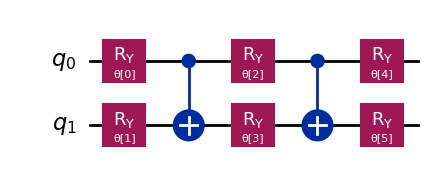

Optimal Parameters: [1.7262871  5.48122901 0.0140801  0.00667839 4.55631395 3.94372629]
Minimum Cost: 3.0560529902520306e-06


In [21]:
from qiskit import QuantumCircuit,transpile
from qiskit.quantum_info import SparsePauliOp,DensityMatrix
from qiskit.circuit.library import TwoLocal,n_local
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2
from qiskit.quantum_info import Operator
from scipy.optimize import minimize
import numpy as np

estimator = EstimatorV2()

II = SparsePauliOp.from_list([("II", 1.0)])

#Step 1: Operator A
A_mat = np.array([[4,1,0,0],[1,3,1,0],[0,1,2,1],[0,0,1,1]])
A_op = SparsePauliOp.from_operator(A_mat)

#Step 2: |b> vector normalized, encoding in circuit and creating a density matrix |b><b|
b_vec = np.array([0, 1, 2, 1])
b_vec = b_vec / np.linalg.norm(b_vec)
b_mat = DensityMatrix(b_vec)
b_op = SparsePauliOp.from_operator(b_mat)

#step 3: Cost Hamiltonian
Ham = A_op @ (II - b_op) @ A_op

#checking H is hermitian
print("Is Hermitian?", np.allclose(Ham.to_matrix(), Ham.to_matrix().conj().T))

#Checking any imaginary coefficients
print("Imag part of coeffs:", np.imag(Ham.coeffs).max())

#Display the Hamiltonian as matrix
print("Cost_Hamiltonian:",Ham.to_matrix())

# Make the operator Hermitian (just in case)
Ham = 0.5 * (Ham + Ham.adjoint())

# Strip all imaginary parts: only real part is needed
Ham = SparsePauliOp(Ham.paulis, coeffs=np.real(Ham.coeffs))

#Step 4: Create ansatz (two-local circuit)

ansatz = n_local(2, rotation_blocks="ry", entanglement_blocks="cx", entanglement="linear", reps=2)
display(ansatz.draw("mpl"))
#As for pre-defined circuits, qiskit automatically creates symbolic parameters.
#So to create a circuit with parameters, one has to use "bind_parameters(params)" function; It replaces them with numerical values

#Step 5: evaluate cost function
def costfunc(params):
    #state = ansatz.bind_parameters(params)
    job = estimator.run([(ansatz,Ham,params)])
    result = job.result()
    value  = result[0].data.evs
    return value

#step 6: optimization
initial_params = np.random.uniform(0, 2*np.pi, size=ansatz.num_parameters)
result = minimize(costfunc, initial_params, method='COBYLA')
print("Optimal Parameters:", result.x)
print("Minimum Cost:", result.fun)


To get the solution from above parameters and compare with the classical solution.

In [22]:
# To create the statevector from above optimal values
from qiskit.quantum_info import Statevector

# Create circuit with optimal parameters
optimal_params = result.x
optimal_circuit = ansatz.assign_parameters(optimal_params)

# Get statevector from the circuit
statevector = Statevector.from_instruction(optimal_circuit)

# Show vector (solution |x⟩)
print("Approximate solution |x⟩:", statevector.data)
display(statevector.draw("latex"))


Approximate solution |x⟩: [ 4.11285382e-04+0.j -1.59312402e-03+0.j  9.99984311e-01+0.j
 -5.35453612e-03+0.j]


<IPython.core.display.Latex object>

In [23]:
#Classsical Solution
# Original A matrix
Acl = np.array([[4,1,0,0],
              [1,3,1,0],
              [0,1,2,1],
              [0,0,1,1]])

# Original b vector
bcl = np.array([0,1,2,1])
bcl = bcl / np.linalg.norm(bcl)

# Classical solution
x_classical = np.linalg.solve(Acl, bcl)
x_classical = x_classical / np.linalg.norm(x_classical)  # normalized for comparison
print("Classical normalized solution:", x_classical)


Classical normalized solution: [0. 0. 1. 0.]


In [24]:
#Comparison
# Quantum state from VQLS
x_quantum = statevector.data
x_quantum = x_quantum / np.linalg.norm(x_quantum)

# Inner product (fidelity)
fidelity = np.abs(np.dot(np.conj(x_classical), x_quantum)) ** 2

print(f"Fidelity between quantum and classical solutions: {fidelity:.6f}")


Fidelity between quantum and classical solutions: 0.999969
